In [1]:
# train on whole corpus
# initialize to Google News embeddings
# train using skip gram example
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb
# hopefully gets reasonable word vectors for interesting bigrams like 'the fed'
from __future__ import print_function
import collections
import random
import math
import pickle

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import tensorflow as tf

import gensim
import logging

from matplotlib import pylab
%matplotlib inline

import operator
import nltk
from nltk.collocations import *
#nltk.download('punkt')

# fix random seed for reproducibility
np.random.seed(7)

from pprint import pprint



In [2]:
#!scp -i ~/2017.pem ubuntu@54.234.245.245:/var/sites/streeteye_project/streeteye/octave/dump_2017_words.txt .
#data_file = "dump_2018_code.txt"
data_file = "headline_lemmas_id_positive.txt"


In [3]:
############################################################
# 1. load data
############################################################

# load dataset
print("Loading data...")
data=[]
metadata=[]
y=[]

# count words
c = collections.Counter()

count = 0
with open(data_file, "r") as infile:
    for line in infile:
        id, headline = line.strip().split("|")[:2]

        count += 1
        if count % 50000 == 0:
            print (count)

        # skip empty headlines
        if len(headline) == 0:
            continue
        words = headline.split()
        
        data.append(words)
        c.update(words)
        
print("Loaded %d lines." % count)


Loading data...
50000
100000
150000
200000
250000
Loaded 255818 lines.


In [4]:
# dump data as one giant text string

with open("dump_words.txt", "w") as outfile:
    for headline in data:
        for word in headline:
            outfile.write(word)
            outfile.write(" ")


In [5]:
def read_data(filename):
  """Extract the file as a list of words"""
  with open(filename) as f:
    data = tf.compat.as_str(f.read()).split()
  return data

filename = "dump_words.txt"
words = read_data(filename)
print('Data size %d' % len(words))

Data size 2290478


In [6]:
############################################################
# build dataset
############################################################

vocabulary_size = 15000 # pick this to have ~10 occurrences for least popular

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:100])
print("\n")
print('Least common words', count[-10:])
print("\n")
print('Sample data', data[:100])


Most common words (+UNK) [['UNK', 168465], ('trump', 18956), ('us', 16104), ('bloomberg', 15114), ('say', 13555), ('reuters', 11535), ('new', 10900), ('new_york_times', 8685), ('washington_post', 8063), ('china', 7883), ('wall_street_journal', 7805), ('financial_times', 7345), ('the_guardian', 5868), ('make', 5781), ('year', 5698), ('get', 5598), ('cnbc', 5489), ('2018', 5128), ('market', 4945), ('instagram', 4876), ('could', 4703), ('amazon', 4647), ('world', 4646), ('report', 4610), ('time', 4577), ('big', 4415), ('million', 4370), ('plan', 4229), ('take', 4147), ('brexit', 3885), ('youtube', 3864), ('billion', 3774), ('company', 3761), ('one', 3689), ('blockchain', 3652), ('go', 3639), ('may', 3637), ('facebook', 3637), ('cnn', 3618), ('woman', 3604), ('deal', 3573), ('bank', 3489), ('stock', 3475), ('trade', 3466), ('use', 3425), ('uk', 3413), ('call', 3392), ('business', 3345), ('first', 3344), ('show', 3324), ('american', 3300), ('want', 3226), ('medium', 3201), ('people', 3136),

In [7]:
############################################################
# function to generate mini batches
############################################################

# generate pairs of words that are collocated as two parallel lists
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])



data: ['todd', 'sullivan', 'instagram', 'dont', 'even', 'try', 'hide', 'UNK']

with num_skips = 2 and skip_window = 1:
    batch: ['sullivan', 'sullivan', 'instagram', 'instagram', 'dont', 'dont', 'even', 'even']
    labels: ['instagram', 'todd', 'dont', 'sullivan', 'instagram', 'even', 'dont', 'try']

with num_skips = 4 and skip_window = 2:
    batch: ['instagram', 'instagram', 'instagram', 'instagram', 'dont', 'dont', 'dont', 'dont']
    labels: ['even', 'sullivan', 'todd', 'dont', 'instagram', 'try', 'sullivan', 'even']


In [8]:
# Initialize embeddings to random values or Google News embedddings where available

embedding_size = 300 # Dimension of the embedding vector.
print ("Initializing random embeddings")
initial_vals = np.float32(np.random.uniform(-1,1,size=(vocabulary_size,embedding_size)))

# Look up Google News embeddings and replace where they exist
print ("Loading Google News embedding model")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# do this once each session, takes a while
try:
    model
except NameError:
    model = gensim.models.KeyedVectors.load_word2vec_format('~/Notebooks/GoogleNews-vectors-negative300.bin', binary=True)

#copy file above to ramdisk to maybe speedup
#sudo mount -t tmpfs -o size=4096m tmpfs /home/ubuntu/mount/ramdisk

#print(model['computer'])
#print(dictionary['computer'])
#print(reverse_dictionary[2297])
#model.similarity('computer', 'PC')
#print(initial_vals[2297])

print ("Re-initializing to Google News embedding where available")
# for each word in model, use its embeddings as initial val

count = 0
for (v,k) in reverse_dictionary.items():
    if k in model:
        count+=1
        if (count % 1000) == 0:
            print ("Re-initialized %d words" % count)
        initial_vals[v] = model[k]

print ("Re-initialized %d of %d words" % (count,vocabulary_size))
# delete model which takes up a lot of memory (5-6 GB)
del model

2018-11-14 12:58:23,040 : INFO : loading projection weights from ~/Notebooks/GoogleNews-vectors-negative300.bin


Initializing random embeddings
Loading Google News embedding model


2018-11-14 12:58:49,321 : INFO : loaded (3000000, 300) matrix from ~/Notebooks/GoogleNews-vectors-negative300.bin


Re-initializing to Google News embedding where available
Re-initialized 1000 words
Re-initialized 2000 words
Re-initialized 3000 words
Re-initialized 4000 words
Re-initialized 5000 words
Re-initialized 6000 words
Re-initialized 7000 words
Re-initialized 8000 words
Re-initialized 9000 words
Re-initialized 10000 words
Re-initialized 11000 words
Re-initialized 11623 of 15000 words


In [9]:
############################################################
# word2vec computation graph
############################################################

batch_size = 128
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 20 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    tf_learning_rate = tf.placeholder(tf.float32)
    
    # Variables.
    embeddings = tf.Variable(initial_vals)
    # (initialize to random or Google News value from previous cell)
    # tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_labels, embed,
                                                     num_sampled, vocabulary_size))
    
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    optimizer = tf.train.AdagradOptimizer(tf_learning_rate).minimize(loss)
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    
    # initialize op
    init_op = tf.global_variables_initializer()
  



Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


2018-11-14 12:58:56,490 : WARNING : From /home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:1124: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [10]:
############################################################
# run computation graph
############################################################
num_steps = 2000001

# high initial learning rate, reduce gradually
initial_lr = 1.0
final_lr = 0.1
#final_lr = 0.01
lr_reduce_rate=(final_lr / initial_lr) ** (1.0/num_steps)
print("lr_reduce_rate: %.10f" % lr_reduce_rate)

with tf.Session(graph=graph) as session:
    session.run(init_op)
    average_loss = 0
    lr = initial_lr
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        #print(batch_data)
        #print(batch_labels.shape)
        feed_dict = {train_dataset : batch_data, 
                     train_labels : batch_labels, 
                     tf_learning_rate : lr,}
        _, l = session.run([optimizer, loss], 
                           feed_dict=feed_dict,)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
        lr *= lr_reduce_rate
        
    final_embeddings = normalized_embeddings.eval()

    

lr_reduce_rate: 0.9999980812
Nearest to associated_press: tantrum, booster, wolinskys, performance, billionaire, rant, vancouver, blackface,
Nearest to 2018: whitey, inauthentic, equivalent, entitlement, stereotype, claim, mandatory, punch,
Nearest to instagram: midnight, istanbul, beer, lamborghini, liquor, since, bny, hold,
Nearest to top: highest, fifth, ranking, sixth, bottom, seventh, atop, best,
Nearest to bank: banks, banking, lender, banker, branch, brokerage, lending, deposit,
Nearest to year: month, week, decade, years, summer, weeks, season, weekend,
Nearest to work: working, job, done, collaborate, hire, diligence, apprenticeship, operate,
Nearest to kavanaugh: 2023, people_com, kqed_org, financier, phys_org, whalen, sixth_tone, complacent,
Nearest to future: upcoming, current, potential, someday, next, uncertain, continue, forthcoming,
Nearest to deal: agreement, pact, contract, accord, buyout, negotiating, merger, negotiate,
Nearest to bitcoin: handelsblatt, dispatch, str

Average loss at step 42000: 3.304097
Average loss at step 44000: 3.298531
Average loss at step 46000: 3.299778
Average loss at step 48000: 3.318288
Average loss at step 50000: 3.334386
Nearest to associated_press: newsweek, voa, boing_boing, chicago_tribune, politico, yahoo, mashable, washington_post,
Nearest to 2018: result, 2017, update, season, surpasses, pdf, revenue, 2019,
Nearest to instagram: jan, feb, guy, leigh, enjoy, quite, photo, linkedin,
Nearest to top: senior, poaches, influential, ranked, atop, highest, prominent, biggest,
Nearest to bank: banks, lender, banking, branch, deposit, brokerage, banker, central_bank,
Nearest to year: month, years, decade, autumn, weeks, nearly, quarter, beginning,
Nearest to work: working, employ, employed, innovate, utilize, exist, rely, workplace,
Nearest to kavanaugh: confirmation, accuser, brett, nominee, honorable, cohen, hearing, internal,
Nearest to future: dystopian, viable, bright, sustainable, revolutionize, futuristic, environment

Average loss at step 92000: 3.196063
Average loss at step 94000: 3.205969
Average loss at step 96000: 3.197143
Average loss at step 98000: 3.163178
Average loss at step 100000: 3.152031
Nearest to associated_press: new_york_times, washington_post, nbc_news, politico, bloomberg, voa, cnbc, the_hill,
Nearest to 2018: season, 2017, 2019, refresh, september, committee, anniversary, preview,
Nearest to instagram: jan, feb, linkedin, pitchfork, sleeping, boston_globe, new_york_times, forexlive,
Nearest to top: senior, poaches, highest, outpaces, nabs, atop, influential, ranked,
Nearest to bank: banks, lender, banking, branch, deposit, brokerage, lending, banker,
Nearest to year: month, years, decade, week, autumn, weeks, quarter, yr,
Nearest to work: working, employ, collaborate, workplace, apprenticeship, employed, innovate, outsource,
Nearest to kavanaugh: confirmation, honorable, brett, kavanaughs, impeach, accuser, swear, reminder,
Nearest to future: dystopian, viable, fully, futuristic,

Average loss at step 138000: 3.036263
Average loss at step 140000: 2.989877
Nearest to associated_press: politico, new_york_times, nbc_news, washington_post, voa, bloomberg, huffington_post, reuters,
Nearest to 2018: 2017, 2019, season, recap, overview, result, september, anniversary,
Nearest to instagram: jan, feb, ayesha, sunrise, linkedin, the_atlantic, youtube, entrepreneur,
Nearest to top: highest, senior, atop, ranked, outpaces, poaches, influential, leading,
Nearest to bank: banks, lender, branch, brokerage, banking, deposit, fsa, unbanked,
Nearest to year: years, month, weeks, decade, day, week, per_cent, minute,
Nearest to work: working, employ, workplace, employed, apprenticeship, happy, workweek, disability,
Nearest to kavanaugh: confirmation, honorable, brett, kavanaughs, impeach, accuser, obstruction, clinton,
Nearest to future: dystopian, fully, derived, viable, competitiveness, remotely, advancement, using,
Nearest to deal: agreement, pact, impasse, arrangement, merger, 

Average loss at step 182000: 2.907349
Average loss at step 184000: 2.939807
Average loss at step 186000: 2.946944
Average loss at step 188000: 2.972902
Average loss at step 190000: 2.959327
Nearest to associated_press: voa, nbc_news, politico, the_hill, new_york_times, washington_post, reuters, bloomberg,
Nearest to 2018: 2017, 2019, refresh, expiry, year, final, glory, gurdgiev,
Nearest to instagram: jan, feb, ayesha, sunrise, sunset, linkedin, ufo, lisbon,
Nearest to top: poaches, senior, highest, atop, trusted, hottest, influential, outpaces,
Nearest to bank: banks, lender, banking, unbanked, fsa, deposit, branch, exporter,
Nearest to year: years, month, decade, weeks, yr, week, km, tenth,
Nearest to work: working, employ, outsource, innovate, workplace, employed, workforce, rely,
Nearest to kavanaugh: brett, honorable, confirmation, kavanaughs, accuser, impeach, clinton, reminder,
Nearest to future: dominance, fully, competitiveness, viable, revolutionize, duopoly, advancement, dys

Average loss at step 230000: 2.923685
Nearest to associated_press: voa, washington_post, nbc_news, politico, axios, reuters, wall_street_journal, new_york_times,
Nearest to 2018: 2019, 2017, refresh, expiry, overview, apr, committee, profitability,
Nearest to instagram: jan, feb, ayesha, sunrise, linkedin, lisbon, sunset, ufo,
Nearest to top: atop, hottest, prestigious, highest, poaches, ranked, outpaces, senior,
Nearest to bank: banks, lender, unbanked, banking, fsa, banker, creditor, debit,
Nearest to year: month, years, yr, weeks, week, decade, per_cent, year_ago,
Nearest to work: working, employ, workplace, outsource, innovate, implement, collaborate, use,
Nearest to kavanaugh: brett, honorable, kavanaughs, confirmation, impeach, accuser, clinton, pelosi,
Nearest to future: competitiveness, viable, platform, dominance, readiness, dystopian, optimal, litecoin,
Nearest to deal: pact, agreement, merger, bargain, brexit_deal, impasse, concession, arrangement,
Nearest to bitcoin: crypto

Average loss at step 272000: 2.830948
Average loss at step 274000: 2.835684
Average loss at step 276000: 2.786115
Average loss at step 278000: 2.812232
Average loss at step 280000: 2.790926
Nearest to associated_press: new_york_times, nbc_news, washington_post, bloomberg, politico, reuters, voa, new_yorker,
Nearest to 2018: 2017, 2019, symposium, expiry, committee, profitability, season, delegate,
Nearest to instagram: jan, ayesha, sunrise, feb, linkedin, ufo, guy, purple,
Nearest to top: atop, highest, hottest, ranked, poaches, outpaces, prestigious, key,
Nearest to bank: banks, lender, banking, unbanked, banker, brokerage, refiner, branch,
Nearest to year: years, month, decade, week, forty, year_ago, yr, weeks,
Nearest to work: working, employ, workplace, workforce, attend, rely, disability, innovate,
Nearest to kavanaugh: kavanaughs, brett, confirmation, accuser, honorable, classmate, clinton, impeach,
Nearest to future: competitiveness, litecoin, forever, savior, advancement, fork,

Average loss at step 318000: 2.727082
Average loss at step 320000: 2.750173
Nearest to associated_press: nbc_news, new_york_times, reuters, washington_post, voa, bloomberg, new_yorker, politico,
Nearest to 2018: 2017, 2019, expiry, profitability, season, overview, gurdgiev, unaudited,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, guy, ufo, illustration,
Nearest to top: hottest, poaches, atop, ranked, highest, prestigious, sigma, senior,
Nearest to bank: banks, lender, banking, unbanked, branch, brokerage, insolvent, debit,
Nearest to year: years, month, decade, year_ago, yr, km, tenth, forty,
Nearest to work: working, employ, employed, innovate, workplace, occupational, rely, collaborate,
Nearest to kavanaugh: kavanaughs, brett, confirmation, honorable, classmate, impeach, accuser, trump,
Nearest to future: optimal, litecoin, advancement, competitiveness, derived, fully, lifespan, sustainable,
Nearest to deal: agreement, pact, brexit_deal, impasse, arrangement, merger, ten

Average loss at step 362000: 2.770224
Average loss at step 364000: 2.770842
Average loss at step 366000: 2.760527
Average loss at step 368000: 2.791508
Average loss at step 370000: 2.783408
Nearest to associated_press: washington_post, nbc_news, new_york_times, bloomberg, axios, voa, politico, new_yorker,
Nearest to 2018: 2019, 2017, expiry, refresh, profitability, unaudited, overview, thu,
Nearest to instagram: jan, sunrise, feb, ayesha, linkedin, paddle, sunset, ufo,
Nearest to top: poaches, hottest, atop, outpaces, expects, highest, key, senior,
Nearest to bank: banks, lender, banking, unbanked, banker, rbs, creditor, refiner,
Nearest to year: years, month, per_cent, week, weeks, forty, year_ago, decade,
Nearest to work: working, employ, employed, outsource, collaborate, rely, discriminate, workplace,
Nearest to kavanaugh: kavanaughs, brett, confirmation, honorable, impeach, clinton, accuser, judiciary,
Nearest to future: litecoin, optimal, competitiveness, viable, humankind, advanc

Average loss at step 408000: 2.711755
Average loss at step 410000: 2.719787
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, reuters, wall_street_journal, politico, the_hill,
Nearest to 2018: 2017, 2019, expiry, refresh, profitability, season, years, delegate,
Nearest to instagram: jan, feb, sunrise, ayesha, linkedin, ufo, pitchfork, vancouversun_com,
Nearest to top: atop, poaches, highest, hottest, senior, ranked, outpaces, trusted,
Nearest to bank: banks, lender, banking, refiner, unbanked, rbs, firm, brokerage,
Nearest to year: month, years, week, per_cent, tumultuous, decade, year_ago, km,
Nearest to work: working, employ, workplace, rely, employed, worker, collaborate, outsource,
Nearest to kavanaugh: kavanaughs, brett, confirmation, honorable, clinton, accuser, impeach, judiciary,
Nearest to future: fork, litecoin, competitiveness, optimal, advancement, derived, type, sphere,
Nearest to deal: agreement, pact, brexit_deal, impasse, merger, arrange

Average loss at step 450000: 2.656424
Nearest to associated_press: washington_post, nbc_news, new_york_times, bloomberg, reuters, politico, new_yorker, voa,
Nearest to 2018: 2017, 2019, profitability, expiry, delegate, season, blowout, tsunami,
Nearest to instagram: jan, sunrise, ayesha, feb, ufo, linkedin, guy, youtube,
Nearest to top: atop, hottest, poaches, ranked, outpaces, highest, sigma, key,
Nearest to bank: banks, banking, lender, banker, unbanked, rbs, refiner, firm,
Nearest to year: years, month, week, decade, year_ago, tenth, yr, per_cent,
Nearest to work: working, employ, workplace, workforce, attend, employed, career, worker,
Nearest to kavanaugh: kavanaughs, brett, confirmation, honorable, clinton, impeach, accuser, judiciary,
Nearest to future: litecoin, advancement, optimal, fork, competitiveness, type, insurtech_insider_by_11, humankind,
Nearest to deal: agreement, pact, brexit_deal, impasse, merger, arrangement, stalemate, partnership,
Nearest to bitcoin: cryptocurren

Average loss at step 492000: 2.632655
Average loss at step 494000: 2.665930
Average loss at step 496000: 2.690073
Average loss at step 498000: 2.678733
Average loss at step 500000: 2.682146
Nearest to associated_press: washington_post, new_york_times, nbc_news, new_yorker, bloomberg, axios, voa, the_hill,
Nearest to 2018: 2017, 2019, expiry, delegate, profitability, refresh, blowout, unaudited,
Nearest to instagram: jan, sunrise, ayesha, feb, ufo, linkedin, paddle, guy,
Nearest to top: atop, poaches, outpaces, hottest, highest, trusted, senior, key,
Nearest to bank: banks, lender, banking, unbanked, banker, rbs, brokerage, firm,
Nearest to year: years, month, decade, year_ago, yr, km, tenth, forty,
Nearest to work: working, employ, workplace, workforce, rely, innovate, employed, discriminate,
Nearest to kavanaugh: kavanaughs, brett, confirmation, honorable, accuser, clinton, judiciary, classmate,
Nearest to future: litecoin, advancement, insurtech_insider_by_11, optimal, fork, disrupt,

Average loss at step 540000: 2.679917
Nearest to associated_press: washington_post, nbc_news, new_york_times, bloomberg, axios, new_yorker, reuters, voa,
Nearest to 2018: 2017, 2019, expiry, delegate, refresh, profitability, unaudited, blowout,
Nearest to instagram: jan, sunrise, ayesha, feb, linkedin, ufo, illustration, paddle,
Nearest to top: atop, hottest, poaches, prestigious, highest, outpaces, skip, roughly,
Nearest to bank: banks, lender, banking, unbanked, banker, firm, rbs, refiner,
Nearest to year: years, month, decade, year_ago, per_cent, km, week, yr,
Nearest to work: working, employ, use, rely, discriminate, workplace, employed, workforce,
Nearest to kavanaugh: kavanaughs, brett, confirmation, accuser, honorable, clinton, judiciary, classmate,
Nearest to future: litecoin, optimal, sphere, advancement, humankind, type, derived, fork,
Nearest to deal: agreement, pact, brexit_deal, merger, impasse, agree, partnership, arrangement,
Nearest to bitcoin: cryptocurrency, crypto, c

Average loss at step 582000: 2.615220
Average loss at step 584000: 2.572781
Average loss at step 586000: 2.605281
Average loss at step 588000: 2.576810
Average loss at step 590000: 2.568613
Nearest to associated_press: new_york_times, washington_post, nbc_news, bloomberg, reuters, new_yorker, the_guardian, politico,
Nearest to 2018: 2017, 2019, expiry, delegate, profitability, blowout, tsunami, season,
Nearest to instagram: jan, sunrise, ayesha, linkedin, ufo, feb, guy, vancouversun_com,
Nearest to top: atop, hottest, poaches, outpaces, highest, sigma, outperforms, senior,
Nearest to bank: banks, banking, lender, rbs, unbanked, banker, brokerage, firm,
Nearest to year: years, month, decade, year_ago, km, yr, week, per_cent,
Nearest to work: working, employ, workplace, workforce, disability, employed, employee, quite,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, honorable, classmate, clinton, blasey_ford,
Nearest to future: litecoin, optimal, type, fork, advancement, 

Average loss at step 626000: 2.543469
Average loss at step 628000: 2.574652
Average loss at step 630000: 2.579505
Nearest to associated_press: new_york_times, washington_post, nbc_news, new_yorker, bloomberg, reuters, axios, voa,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, committee, unaudited, season,
Nearest to instagram: jan, sunrise, ayesha, linkedin, ufo, guy, feb, vancouversun_com,
Nearest to top: atop, poaches, hottest, highest, outperforms, outpaces, trusted, prestigious,
Nearest to bank: banks, lender, banking, unbanked, rbs, banker, firm, refiner,
Nearest to year: years, month, km, decade, year_ago, yr, per_cent, forty,
Nearest to work: working, employ, disability, workplace, workforce, employee, employed, innovate,
Nearest to kavanaugh: kavanaughs, brett, confirmation, accuser, honorable, classmate, clinton, judiciary,
Nearest to future: litecoin, optimal, advancement, type, fork, derived, competitiveness, humankind,
Nearest to deal: agreement, pact, brexit_deal,

Average loss at step 672000: 2.603920
Average loss at step 674000: 2.601999
Average loss at step 676000: 2.631158
Average loss at step 678000: 2.620759
Average loss at step 680000: 2.585596
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, new_yorker, axios, reuters, politico,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, thu, profitability, refresh,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, ufo, paddle, guy,
Nearest to top: atop, poaches, hottest, highest, outpaces, trusted, dangles, outperforms,
Nearest to bank: banks, lender, banking, unbanked, firm, rbs, banker, refiner,
Nearest to year: years, month, km, per_cent, decade, week, yr, year_ago,
Nearest to work: working, employ, use, workforce, discriminate, employed, rely, relies,
Nearest to kavanaugh: kavanaughs, brett, confirmation, accuser, honorable, clinton, classmate, judiciary,
Nearest to future: litecoin, optimal, advancement, derived, draper, fork, type, sphere,
Nea

Average loss at step 720000: 2.530512
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, new_yorker, reuters, axios, politico,
Nearest to 2018: 2017, 2019, expiry, delegate, season, blowout, profitability, tsunami,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, ufo, guy, vancouversun_com,
Nearest to top: atop, poaches, highest, hottest, outpaces, outperforms, key, sigma,
Nearest to bank: banks, lender, banking, unbanked, banker, rbs, firm, refiner,
Nearest to year: years, month, week, tumultuous, km, per_cent, decade, sober,
Nearest to work: working, employ, workforce, employed, rely, attend, use, employee,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, honorable, clinton, judiciary, classmate,
Nearest to future: litecoin, optimal, type, fork, advancement, draper, derived, sphere,
Nearest to deal: agreement, pact, brexit_deal, merger, impasse, agree, buyout, arrangement,
Nearest to bitcoin: cryptocurrency, crypto, cryptocurre

Average loss at step 762000: 2.501710
Average loss at step 764000: 2.506102
Average loss at step 766000: 2.533569
Average loss at step 768000: 2.569479
Average loss at step 770000: 2.582898
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, new_yorker, reuters, axios, politico,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, unaudited, profitability, tsunami,
Nearest to instagram: jan, sunrise, ayesha, feb, linkedin, guy, ufo, paddle,
Nearest to top: hottest, atop, poaches, outpaces, outperforms, highest, trusted, senior,
Nearest to bank: banks, lender, banking, unbanked, rbs, firm, banker, refiner,
Nearest to year: years, month, km, decade, year_ago, yr, week, per_cent,
Nearest to work: working, employ, asbestos, disability, discriminate, workplace, workforce, rely,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, classmate, judiciary, clinton, honorable,
Nearest to future: litecoin, optimal, fork, type, advancement, draper, deriv

Average loss at step 808000: 2.563797
Average loss at step 810000: 2.559350
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, new_yorker, axios, reuters, the_hill,
Nearest to 2018: 2017, 2019, expiry, delegate, unaudited, blowout, profitability, tsunami,
Nearest to instagram: sunrise, jan, ayesha, linkedin, feb, ufo, guy, illustration,
Nearest to top: hottest, atop, poaches, outpaces, outperforms, highest, trusted, key,
Nearest to bank: banks, lender, banking, unbanked, banker, firm, rbs, refiner,
Nearest to year: month, years, km, yr, year_ago, decade, sober, per_cent,
Nearest to work: working, employ, use, rely, thrive, discriminate, job, workplace,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, judiciary, honorable, classmate,
Nearest to future: litecoin, optimal, derived, type, fork, draper, advancement, insurtech_insider_by_11,
Nearest to deal: agreement, pact, brexit_deal, merger, impasse, partnership, agree, buyout,
Near

Average loss at step 852000: 2.537809
Average loss at step 854000: 2.543290
Average loss at step 856000: 2.520359
Average loss at step 858000: 2.498722
Average loss at step 860000: 2.520616
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, new_yorker, reuters, axios, the_guardian,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, profitability, season, tsunami,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, ufo, guy, vancouversun_com,
Nearest to top: hottest, atop, poaches, outpaces, outperforms, highest, sigma, key,
Nearest to bank: banks, banking, lender, unbanked, firm, banker, rbs, refiner,
Nearest to year: years, month, week, km, per_cent, decade, year_ago, sober,
Nearest to work: working, employ, employee, use, workforce, rely, career, workplace,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, honorable, classmate, judiciary,
Nearest to future: litecoin, optimal, type, advancement, fork, draper, derived, 

Average loss at step 896000: 2.486892
Average loss at step 898000: 2.480390
Average loss at step 900000: 2.470668
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, new_yorker, reuters, axios, the_guardian,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, committee, season, tsunami,
Nearest to instagram: jan, sunrise, ayesha, linkedin, ufo, feb, guy, lisbon,
Nearest to top: hottest, atop, poaches, highest, sigma, outperforms, outpaces, trusted,
Nearest to bank: banks, banking, lender, rbs, unbanked, firm, banker, refiner,
Nearest to year: years, month, km, year_ago, yr, decade, per_cent, week,
Nearest to work: working, employ, employee, rely, workforce, use, job, discriminate,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, judiciary, classmate, blasey_ford,
Nearest to future: litecoin, optimal, advancement, type, fork, derived, draper, insurtech_insider_by_11,
Nearest to deal: agreement, pact, brexit_deal, impasse, merger

Average loss at step 942000: 2.541241
Average loss at step 944000: 2.543480
Average loss at step 946000: 2.537039
Average loss at step 948000: 2.543631
Average loss at step 950000: 2.566271
Nearest to associated_press: washington_post, new_york_times, nbc_news, new_yorker, bloomberg, axios, reuters, the_guardian,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, unaudited, profitability, thu,
Nearest to instagram: sunrise, jan, ayesha, linkedin, feb, ufo, guy, paddle,
Nearest to top: hottest, atop, outpaces, poaches, outperforms, highest, trusted, key,
Nearest to bank: banks, banking, lender, unbanked, firm, rbs, banker, refiner,
Nearest to year: month, years, year_ago, km, decade, yr, per_cent, week,
Nearest to work: working, employ, use, discriminate, rely, employee, asbestos, employed,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, judiciary, honorable, blasey_ford,
Nearest to future: litecoin, optimal, derived, type, advancement, draper, fork, insurt

Average loss at step 990000: 2.511436
Nearest to associated_press: washington_post, new_york_times, nbc_news, new_yorker, bloomberg, reuters, axios, the_guardian,
Nearest to 2018: 2017, 2019, expiry, delegate, thu, committee, unaudited, blowout,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, ufo, guy, paddle,
Nearest to top: hottest, atop, poaches, outpaces, highest, outperforms, key, trusted,
Nearest to bank: banks, lender, banking, unbanked, firm, rbs, banker, refiner,
Nearest to year: month, years, km, week, decade, year_ago, per_cent, tumultuous,
Nearest to work: working, employ, use, workforce, rely, discriminate, career, employee,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, judiciary, honorable, classmate,
Nearest to future: litecoin, optimal, type, fork, draper, derived, advancement, insurtech_insider_by_11,
Nearest to deal: agreement, pact, brexit_deal, merger, impasse, buyout, agree, partnership,
Nearest to bitcoin: cryptocurrency, cryp

Average loss at step 1032000: 2.482543
Average loss at step 1034000: 2.459766
Average loss at step 1036000: 2.440490
Average loss at step 1038000: 2.470236
Average loss at step 1040000: 2.479674
Nearest to associated_press: washington_post, new_york_times, nbc_news, bloomberg, new_yorker, reuters, axios, the_guardian,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, unaudited, committee, tsunami,
Nearest to instagram: jan, sunrise, ayesha, linkedin, ufo, feb, guy, illustration,
Nearest to top: hottest, atop, poaches, outperforms, outpaces, trusted, highest, sigma,
Nearest to bank: banks, lender, banking, unbanked, rbs, banker, firm, refiner,
Nearest to year: years, month, km, year_ago, decade, yr, per_cent, sober,
Nearest to work: working, employ, career, discriminate, workforce, use, employee, rely,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, judiciary, clinton, classmate, blasey_ford,
Nearest to future: litecoin, optimal, type, fork, advancement, derived, d

Average loss at step 1078000: 2.528203
Average loss at step 1080000: 2.521743
Nearest to associated_press: washington_post, new_york_times, nbc_news, new_yorker, bloomberg, reuters, axios, the_guardian,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, unaudited, committee, profitability,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, ufo, guy, illustration,
Nearest to top: hottest, atop, trusted, outpaces, poaches, outperforms, highest, key,
Nearest to bank: banks, lender, banking, unbanked, firm, rbs, banker, refiner,
Nearest to year: years, month, km, year_ago, yr, decade, per_cent, sober,
Nearest to work: working, employ, discriminate, use, workforce, career, employee, asbestos,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, judiciary, classmate, honorable,
Nearest to future: litecoin, optimal, fork, type, derived, advancement, draper, insurtech_insider_by_11,
Nearest to deal: agreement, pact, brexit_deal, merger, impasse, buyout, partner

Average loss at step 1122000: 2.540435
Average loss at step 1124000: 2.503306
Average loss at step 1126000: 2.492531
Average loss at step 1128000: 2.503948
Average loss at step 1130000: 2.459354
Nearest to associated_press: washington_post, new_york_times, nbc_news, new_yorker, bloomberg, reuters, axios, politico,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, committee, profitability, tsunami,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, ufo, guy, vancouversun_com,
Nearest to top: hottest, atop, outpaces, outperforms, poaches, highest, trusted, key,
Nearest to bank: banks, lender, banking, firm, banker, unbanked, rbs, refiner,
Nearest to year: years, month, km, week, per_cent, decade, tumultuous, year_ago,
Nearest to work: working, employ, use, discriminate, career, rely, employee, workforce,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, judiciary, classmate, blasey_ford,
Nearest to future: litecoin, optimal, fork, type, derived, drape

Average loss at step 1170000: 2.456988
Nearest to associated_press: washington_post, new_york_times, nbc_news, new_yorker, bloomberg, reuters, axios, the_guardian,
Nearest to 2018: 2017, 2019, expiry, delegate, blowout, profitability, committee, unaudited,
Nearest to instagram: jan, sunrise, ayesha, linkedin, feb, ufo, guy, vancouversun_com,
Nearest to top: hottest, atop, outperforms, outpaces, poaches, key, trusted, sigma,
Nearest to bank: banks, lender, banking, firm, rbs, banker, unbanked, refiner,
Nearest to year: years, month, km, per_cent, year_ago, yr, decade, week,
Nearest to work: working, employ, career, discriminate, rely, use, workforce, employee,
Nearest to kavanaugh: kavanaughs, brett, accuser, confirmation, clinton, judiciary, classmate, honorable,
Nearest to future: litecoin, optimal, fork, type, draper, derived, advancement, rosneft,
Nearest to deal: agreement, pact, brexit_deal, merger, impasse, buyout, cooperation, agree,
Nearest to bitcoin: cryptocurrency, crypto, c

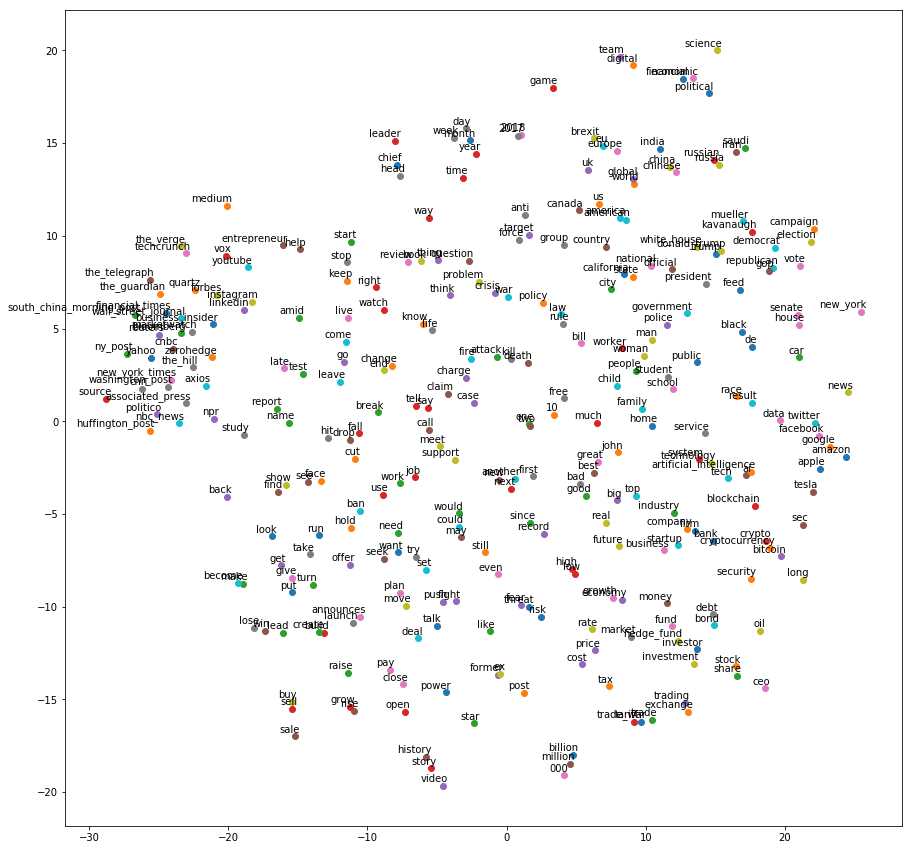

In [11]:
############################################################
# plot in 2D, after transforming 300-vectors with TSNE
############################################################


num_points = 300

tsne = TSNE(perplexity=30,
            n_components=2,
            init='pca',
            n_iter=5000)

two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)


In [12]:
###########################################################
# list collocated words
# allows us to add more mappings for common phrases
############################################################

with open(filename, 'r') as myfile:
        data = myfile.read()
# trigrams with at least 100 occurrences       
tokens = nltk.word_tokenize(data)
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(100)

z = finder.ngram_fd.items()
print(sorted(z, key=operator.itemgetter(1), reverse=True))

# bigrams with at least 200 occurrences       
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(200)
z = finder.ngram_fd.items()
print(sorted(z, key=operator.itemgetter(1), reverse=True))

[(('hedgeco', 'net', 'bloglovin'), 480), (('hedge_fund', 'news', 'hedgeco'), 444), (('news', 'hedgeco', 'net'), 444), (('apple', 'podcasts', 'apple_music'), 323), (('kindle', 'store', 'amazon'), 215), (('amazon', 'co', 'uk'), 201), (('nj_com', 'star', 'ledger'), 141), (('us', 'china_trade', 'war'), 125), (('whats', 'leave', 'economy'), 117), (('60', 'second', 'video'), 112), (('news', 'top', 'story'), 111), (('top', 'story', 'the_straits_times'), 111), (('instagram_photo', 'video', 'instagram'), 110), (('saudi', 'crown', 'prince'), 101)]
[(('david_tawil', 'linkedin'), 905), (('amazon_com_book', 'amazon'), 876), (('trump', 'say'), 700), (('brett', 'kavanaugh'), 629), (('trump', 'tariff'), 566), (('say', 'bloomberg'), 544), (('hedgeco', 'net'), 480), (('net', 'bloglovin'), 480), (('bloomberg', 'trump'), 448), (('hedge_fund', 'news'), 444), (('news', 'hedgeco'), 444), (('book', 'amazon'), 388), (('10', 'year'), 388), (('source', 'reuters'), 362), (('utc', 'instagram'), 358), (('deal', 'br

In [13]:
finder.ngram_fd.items()

dict_items([(('wall_street_journal', 'trump'), 229), (('trump', 'trade_war'), 247), (('themotleyfool', 'stock'), 218), (('trump', 'tariff'), 566), (('deal', 'brexit'), 355), (('amazon_com_book', 'amazon'), 876), (('book', 'amazon'), 388), (('report', 'the_hill'), 274), (('us', 'sanction'), 238), (('new_york_times', 'trump'), 272), (('jon_najarian', 'instagram'), 294), (('us', 'china_trade'), 269), (('reuters', 'us'), 238), (('need', 'know'), 345), (('us', 'trade'), 237), (('bloomberg', 'us'), 256), (('bloomberg', 'trump'), 448), (('kindle', 'store'), 215), (('store', 'amazon'), 216), (('apple', 'podcasts'), 326), (('podcasts', 'apple_music'), 323), (('trump', 'say'), 700), (('bloomberg', 'china'), 211), (('us', 'china'), 223), (('co', 'founder'), 218), (('post', 'brexit'), 224), (('globe_', '_mail'), 331), (('reuters', 'china'), 202), (('source', 'reuters'), 362), (('amazon', 'co'), 202), (('co', 'uk'), 213), (('source', 'say'), 200), (('say', 'bloomberg'), 544), (('10', 'year'), 388),

In [14]:
############################################################
# dump pickle file of embeddings
############################################################

mydict = {}
myreverse = {}

for i in range(vocabulary_size):
    k = reverse_dictionary[i]
    e = final_embeddings[i]
    mydict[k]=i
    myreverse[i]=k

pickle_list = [mydict, myreverse, final_embeddings]

output = open('embeddings.pkl', 'wb')
pickle.dump(pickle_list, output)
output.close()

In [ ]:
############################################################
# dump files for embeddings projector
############################################################

# visualize embeddings
# put files somewhere accessible and run via 
# http://projector.tensorflow.org/
    
file1 = 'streeteye_test1.tsv'
file2 = 'streeteye_test2.tsv'

print("creating file %s" % file1)
with open(file1, 'w') as outfile:
    for i in range(vocabulary_size):
        e = final_embeddings[i]
        outfile.write("\t".join(["%f" % val for val in e]))
        outfile.write("\n")

print("creating file %s" % file2)
with open(file2, 'w') as outfile:
    #outfile.write("word\n")
    for i in range(vocabulary_size):
        w = reverse_dictionary[i]
        outfile.write(w)
        outfile.write("\n")


z = [    (('alex', 'jones'), 329),
    (('all', 'time'), 374),
    (('amazon', 'com'), 4627),
    (('artificial', 'intelligence'), 1391),
    (('asset', 'management'), 1115),
    (('associate', 'press'), 1966),
    (('associated', 'press'), 1966),
    (('attorney', 'general'), 431),
    (('bank', 'america'), 1014),
    (('bank', 'england'), 1594),
    (('barack', 'obama'), 253),
    (('basic', 'income'), 105),
    (('ben', 'carson'), 1063),
    (('bernie', 'sander'), 5528),
    (('big', 'data'), 476),
    (('bill', 'gate'), 234),
    (('bond', 'market'), 1200),
    (('border', 'wall'), 112),
    (('central', 'bank'), 6407),
    (('chief', 'executive'), 3278),
    (('chris', 'christie'), 1023),
    (('climate', 'change'), 2769),
    (('climate', 'deal'), 112),
    (('credit', 'card'), 1356),
    (('credit', 'suisse'), 1345),
    (('david', 'cameron'), 1475),
    (('deal', 'with'), 1238),
    (('democratic', 'party'), 1005),
    (('democratic', 'presidential'), 1083),
    (('deutsche', 'bank'), 2021),
    (('do', 'not'), 1037),
    (('dodd', 'frank'), 349),
    (('donald', 'trump'), 21304),
    (('economic', 'data'), 1911),
    (('economic', 'growth'), 1913),
    (('elizabeth', 'warren'), 238),
    (('emerge', 'market'), 1551),
    (('emmanuel', 'macron'), 306),
    (('european', 'union'), 2403),
    (('executive', 'order'), 711),
    (('fake', 'news'), 1945),
    (('federal', 'reserve'), 6195),
    (('fiduciary', 'rule'), 245),
    (('finance', 'minister'), 1454),
    (('financial', 'crisis'), 2388),
    (('financial', 'market'), 1625),
    (('financial', 'service'), 1091),
    (('first', 'quarter'), 1409),
    (('first', 'time'), 1017),
    (('foreign', 'policy'), 1369),
    (('fourth', 'quarter'), 1409),
    (('fox', 'news'), 1959),
    (('fred', 'economic_data'), 314),
    (('free', 'trade'), 259),
    (('from', 'associate_press'), 1058),
    (('from', 'associated_press'), 1058),
    (('front', 'runner'), 1449),
    (('fund', 'manager'), 2070),
    (('global', 'economy'), 1410),
    (('goldman', 'sachs'), 2744),
    (('health', 'bill'), 115),
    (('health', 'care'), 1530),
    (('health', 'insurance'), 264),
    (('hedge', 'fund'), 13144),
    (('here', 'how'), 1109),
    (('here', 'what'), 1029),
    (('here', 'why'), 527),
    (('high', 'school'), 244),
    (('hillary', 'clinton'), 9139),
    (('hong', 'kong'), 2011),
    (('housing', 'market'), 1732),
    (('human', 'right'), 1089),
    (('immigration', 'ban'), 158),
    (('implode', 'meter'), 138),
    (('insider', 'trading'), 242),
    (('instagram', 'photo'), 1101),
    (('instagram', 'post'), 2118),
    (('interest', 'rate'), 6931),
    (('investment', 'bank'), 1219),
    (('islamic', 'state'), 3666),
    (('ivanka', 'trump'), 752),
    (('james', 'comey'), 360),
    (('jar', 'kushner'), 408),
    (('jeb', 'bush'), 1625),
    (('jeff', 'session'), 532),
    (('jeremy', 'corbyn'), 273),
    (('jp', 'morgan'), 1322),
    (('justice', 'department'), 264),
    (('kellyanne', 'conway'), 421),
    (('know', 'about'), 1191),
    (('long', 'term'), 1966),
    (('los', 'angeles'), 2102),
    (('machine', 'learn'), 263),
    (('machine', 'learning'), 324),
    (('mar', 'lago'), 310),
    (('marco', 'rubio'), 1361),
    (('marine', 'pen'), 324),
    (('mark', 'zuckerberg'), 223),
    (('may', 'have'), 606),
    (('melania', 'trump'), 262),
    (('michael', 'flynn'), 322),
    (('middle', 'east'), 1658),
    (('minimum', 'wage'), 1750),
    (('monetary', 'policy'), 2418),
    (('more', 'than'), 2493),
    (('morgan', 'stanley'), 1322),
    (('muslim', 'ban'), 236),
    (('mutual', 'fund'), 1017),
    (('national', 'review'), 516),
    (('national', 'security'), 115),
    (('national', 'security'), 616),
    (('neil', 'gorsuch'), 236),
    (('net', 'neutrality'), 309),
    (('new', 'jersey'), 1170),
    (('new', 'york'), 18440),
    (('north', 'korea'), 2043),
    (('north', 'korean'), 282),
    (('nuclear', 'deal'), 1846),
    (('oil', 'price'), 317),
    (('panama', 'paper'), 1114),
    (('paul', 'krugman'), 1029),
    (('paul', 'ryan'), 1168),
    (('pension', 'fund'), 222),
    (('per', 'cent'), 1817),
    (('plan', 'parenthood'), 221),
    (('police', 'officer'), 1039),
    (('pope', 'francis'), 1272),
    (('presidential', 'campaign'), 1227),
    (('press', 'conference'), 330),
    (('press', 'release'), 434),
    (('prime', 'minister'), 3781),
    (('private', 'equity'), 1446),
    (('puerto', 'rico'), 18440),
    (('rate', 'hike'), 1710),
    (('real', 'estate'), 485),
    (('republican', 'party'), 1005),
    (('reserve', 'bank'), 1076),
    (('rex', 'tillerson'), 368),
    (('russia', 'investigation'), 286),
    (('russia', 'probe'), 363),
    (('s_p', '500'), 319),
    (('san', 'francisco'), 2345),
    (('saudi', 'arabia'), 1069),
    (('sean', 'spicer'), 508),
    (('second', 'quarter'), 1409),
    (('secretary', 'state'), 1224),
    (('self', 'driving'), 1205),
    (('sexual', 'harassment'), 222),
    (('short', 'term'), 1075),
    (('shut', 'down'), 334),
    (('silicon', 'valley'), 2229),
    (('small', 'business'), 1308),
    (('social', 'medium'), 1338),
    (('social', 'security'), 1092),
    (('south', 'korea'), 428),
    (('state', 'department'), 327),
    (('steve', 'bannon'), 362),
    (('stock', 'exchange'), 1484),
    (('stock', 'market'), 4768),
    (('super', 'bowl'), 1027),
    (('supreme', 'court'), 3248),
    (('tax', 'plan'), 169),
    (('tax', 'plan'), 377),
    (('tax', 'reform'), 499),
    (('ted', 'cruz'), 4319),
    (('terror', 'attack'), 325),
    (('theresa', 'may'), 1917),
    (('third', 'quarter'), 1409),
    (('this', 'week'), 514),
    (('this', 'year'), 1238),
    (('trade', 'deal'), 287),
    (('trade', 'war'), 249),
    (('travel', 'ban'), 1240),
    (('twitter', 'video'), 1282),
    (('unite', 'state'), 5428),
    (('us', 'economy'), 1435),
    (('venture', 'capital'), 234),
    (('vice', 'president'), 1324),
    (('vladimir', 'putin'), 1021),
    (('wall', 'street'), 8408),
    (('warren', 'buffett'), 1042),
    (('washington', 'dc'), 1256),
    (('washington', 'post'), 3308),
    (('well', 'fargo'), 1381),
    (('what', 'do'), 1261),
    (('white', 'house'), 3758),
    (('whole', 'food'), 344),
    (('why', 'do'), 1000),
    (('with', 'vitweet'), 130),
    (('year', 'high'), 1140),
    (('year', 'low'), 1140),
    (('year', 'old'), 1530),
    (('you', 'can'), 1105),
    (('you', 'need'), 1125),
    (('president', 'trump'), 1195),
    (('trump', 'administration'), 884),
    (('united', 'state'), 579),
    (('tax', 'cut'), 480),
    (('elon', 'musk'), 376),
    (('bbc', 'radio'), 264),
    (('tax', 'bill'), 261),
    (('town', 'hall'), 231),
    (('trump', 'campaign'), 223),
    (('alt', 'right'), 222),
    (('white', 'supremacist'), 221),
    (('fbi', 'director'), 209),
(('look', 'like'), 442),
(('what', 'happen'), 429),
(('how', 'do'), 388),
(('how', 'much'), 339),
(('do', 'you'), 332),
(('learn', 'from'), 324),
(('meet', 'with'), 318),
(('free', 'speech'), 311),
(('you', 'think'), 296),
(('roy', 'moore'), 268),
(('lesson', 'from'), 258),
(('charge', 'with'), 251),
(('trump', 'budget'), 242),
(('year', 'ago'), 228),
(('last', 'year'), 221),
(('study', 'find'), 211),
(('fact', 'check'), 210),
(('give', 'up'), 210),
(('step', 'down'), 208),
(('official', 'say'), 207),
(('stand', 'up'), 203),
(('after', 'year'), 202),
(('you_need_know', 'about'), 201),
(('tell', 'us'), 200),
    ]

In [ ]:
zh = dict(z)
sl = []
for k in sorted(zh.keys()):
    sl.append((k, zh[k]))
sl    